## Plot progress of learning from Tensoboard logs

In [1]:
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.style
import seaborn as sns
from scipy import stats
import tensorboard as tb
import numpy as np

In [2]:
plt.rc('font', family='serif')

In [3]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

def get_scores(path):
    event_acc = EventAccumulator(path)
    event_acc.Reload()
    _, _, test = zip(*event_acc.Scalars('mIoU/test'))
    _, _, loss = zip(*event_acc.Scalars('Loss/train'))
    return loss, test

def plot_setup(root, dy_label, baseline_label, annotation_offsets):
    dy_loss, dy_scores = get_scores(f'{root}/dy')
    dy_scores = np.array(dy_scores)*100
    baseline_loss, baseline_scores = get_scores(f'{root}/baseline')
    baseline_scores = np.array(baseline_scores)*100
    fig, (ax_loss, ax_score) = plt.subplots(1, 2, figsize=(16,5))
    # loss
    
    smooth = 25
    dy_loss_hist = np.convolve(dy_loss, np.ones(smooth)/smooth, mode='valid')
    baseline_loss_hist = np.convolve(baseline_loss, np.ones(smooth)/smooth, mode='valid')
    
    ax_loss.plot(range(len(dy_loss_hist)), dy_loss_hist, 'red', label=dy_label)
    ax_loss.plot(range(len(baseline_loss_hist)), baseline_loss_hist, 'k', label=baseline_label)
    ax_loss.set_xlabel('Train batch', fontsize=15)
    ax_loss.set_ylabel('Loss (smoothed)', fontsize=15)
    #ax_loss.set_xlim(5)
    #ax_loss.set_title('Training progress', fontsize=15)
    ax_loss.legend(fontsize=14)
    
    # scores
    ax_score.plot(range(len(dy_scores)), dy_scores, 'r-', label=dy_label, linewidth=2)
    ax_score.plot(range(len(baseline_scores)), baseline_scores, 'k-', label=baseline_label, linewidth=2)
    
    max_dy_score_epoch = np.argmax(dy_scores)
    x, y = (max_dy_score_epoch, dy_scores[max_dy_score_epoch])
    #ax_score.scatter(x, y, s=75, c='r')
    
    ax_score.annotate(f'best {y:.2f}', xy=(x,y),  xycoords='data',
            xytext=(x, y-annotation_offsets[0]), textcoords='data',
            arrowprops=dict(color='red', shrink=0.07, headwidth=9, width=3),
            horizontalalignment='right', verticalalignment='top', fontsize=12)
    
    max_baseline_score_epoch = np.argmax(baseline_scores)
    #ax_score.scatter([max_baseline_score_epoch], [baseline_scores[max_baseline_score_epoch]], s=75, c='k')
    x, y = (max_baseline_score_epoch, baseline_scores[max_baseline_score_epoch])
    ax_score.annotate(f'best {y:.2f}', xy=(x,y),  xycoords='data',
            xytext=(x, y-annotation_offsets[1]), textcoords='data',
            arrowprops=dict(color='black', shrink=0.07, headwidth=9, width=3),
            horizontalalignment='right', verticalalignment='top', fontsize=12)
    
    ax_score.set_xlabel('Epoch', fontsize=15)
    ax_score.set_ylabel('mIoU', fontsize=15)
    #ax_score.set_title('Validation progress', fontsize=15)
    
    ax_score.legend(fontsize=14)

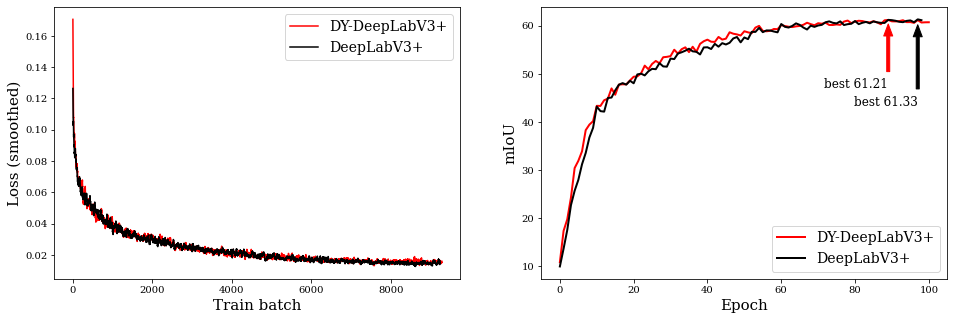

In [4]:
plot_setup("./1.0", "DY-DeepLabV3+", "DeepLabV3+", annotation_offsets=(12, 16))

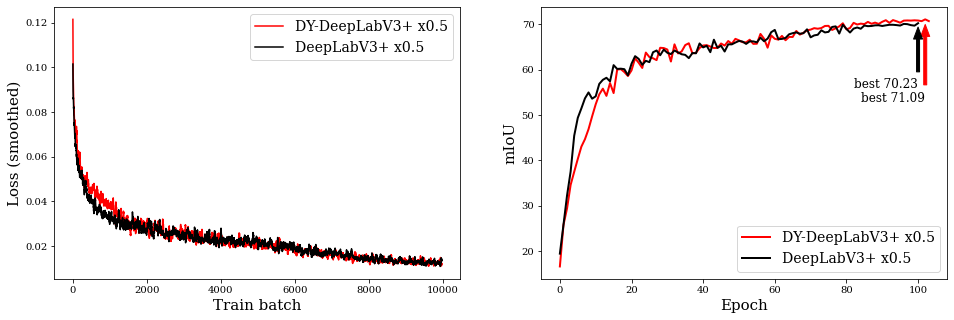

In [5]:
plot_setup("./0.5", "DY-DeepLabV3+ x0.5", "DeepLabV3+ x0.5",  annotation_offsets=(16, 12))

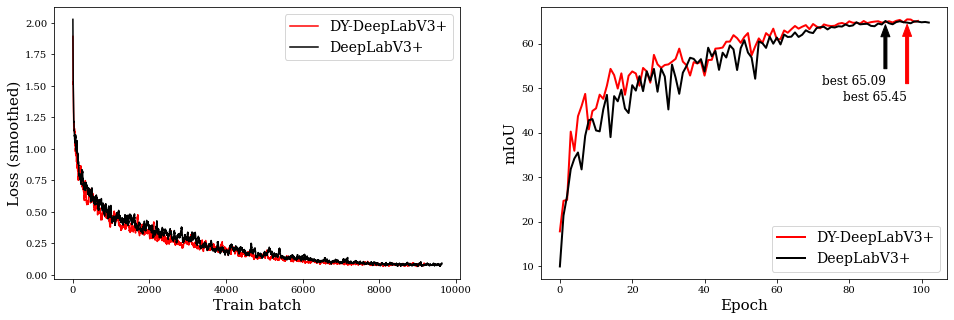

In [6]:
plot_setup("./1.0_no_ba", "DY-DeepLabV3+", "DeepLabV3+", annotation_offsets=(16, 12))

In [7]:
import os
import sys
sys.path.append('../project/')

import torch
import models
from models import common
from models.common import TemperatureScheduler
from utils.options import Options

from utils.utils import load_checkpoint

## Determine number of learnable parameters

In [8]:
def params(t):
    return sum(tt.numel() for tt in t if tt.requires_grad)

def get_n_params(config_path, checkpoint_path):
    model = make_model(config_path, checkpoint_path)
    return params(model.parameters()[0]['params']) + params(model.parameters()[1]['params'])

def make_model(config_path, checkpoint_path):
    opt = Options(config_file_arg="config_path", suppress_parse=True)
    opt.load_from_file(config_path).proc() 
    opt.device = 'cpu'
    model = models.create_model(opt)
    criterion = getattr(common, opt.criterion)(*opt.criterion_args)
    temperature = TemperatureScheduler(*opt.temperature)
    optimizer = getattr(torch.optim, opt.optimizer)(model.parameters(), *opt.optimizer_args)
    scheduler = getattr(torch.optim.lr_scheduler, opt.scheduler)(optimizer, *opt.scheduler_args)
    device = torch.device(opt.device)
    model, epoch, optimizer, scheduler = load_checkpoint(checkpoint_path, model, optimizer, scheduler, device)
    return model


In [9]:
get_n_params("../project/configs/deeplabv3plus_0.5.yaml", "0.5/baseline/cp.pth")

D:\scoopapps\apps\miniconda3\current\envs\torch\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


3409413

In [10]:
get_n_params("../project/configs/dy_deeplabv3plus_0.5.yaml", "0.5/dy/cp.pth")

8444120

In [11]:
get_n_params("../project/configs/deeplabv3plus.yaml", "1.0_no_ba/baseline/cp.pth")

5816053

In [12]:
get_n_params("../project/configs/dy_deeplabv3plus.yaml", "1.0_no_ba/dy/cp.pth")

18414806

## Plot segmentation results

In [60]:
import os
import torch
from torchvision.utils import make_grid
from tensorboardX import SummaryWriter

def decode_seg_map_sequence(label_masks, dataset='pascal'):
    rgb_masks = []
    for label_mask in label_masks:
        rgb_mask = decode_segmap(label_mask, dataset)
        rgb_masks.append(rgb_mask)
    rgb_masks = torch.from_numpy(np.array(rgb_masks).transpose([0, 3, 1, 2]))
    return rgb_masks


def decode_segmap(label_mask, dataset, plot=False):
    """Decode segmentation class labels into a color image
    Args:
        label_mask (np.ndarray): an (M,N) array of integer values denoting
          the class label at each spatial location.
        plot (bool, optional): whether to show the resulting color image
          in a figure.
    Returns:
        (np.ndarray, optional): the resulting decoded color image.
    """
    if dataset == 'pascal' or dataset == 'coco':
        n_classes = 21
        label_colours = get_pascal_labels()
    elif dataset == 'cityscapes':
        n_classes = 19
        label_colours = get_cityscapes_labels()
    else:
        raise NotImplementedError

    r = label_mask.copy()
    g = label_mask.copy()
    b = label_mask.copy()
    for ll in range(0, n_classes):
        r[label_mask == ll] = label_colours[ll, 0]
        g[label_mask == ll] = label_colours[ll, 1]
        b[label_mask == ll] = label_colours[ll, 2]
    rgb = np.zeros((label_mask.shape[0], label_mask.shape[1], 3))
    rgb[:, :, 0] = r / 255.0
    rgb[:, :, 1] = g / 255.0
    rgb[:, :, 2] = b / 255.0
    if plot:
        plt.imshow(rgb)
        plt.show()
    else:
        return rgb
    
def get_pascal_labels():
    """Load the mapping that associates pascal classes with label colors
    Returns:
        np.ndarray with dimensions (21, 3)
    """
    return np.asarray([[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                       [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                       [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                       [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                       [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                       [0, 64, 128]])

def visualize_gt(image, target):
    image_grid = make_grid(image[:3].clone().cpu().data, 3, normalize=True)
    gt_grid = make_grid(decode_seg_map_sequence(torch.squeeze(target[:3], 1).detach().cpu().numpy(),
                                                   dataset='pascal'), 3, normalize=False, range=(0, 255))
    return image_grid, gt_grid

def visualize_output(output):
    return make_grid(decode_seg_map_sequence(torch.max(output[:3], 1)[1].detach().cpu().numpy(),
                                                   dataset='pascal'), 3, normalize=False, range=(0, 255))

In [123]:
def plot_segmentation(image, gt, model_creation_args):
    image_grid, gt_grid = visualize_gt(image, gt)
    image_grid = image_grid.transpose(2,0)
    gt_grid = gt_grid.transpose(2,0)
    fig, ax = plt.subplots(1, 6, figsize=(18, 11))
    ax[0].imshow(image_grid.numpy())
    ax[0].set_xlabel("Image", fontsize=16)
    ax[1].imshow(gt_grid.numpy())
    ax[1].set_xlabel("GT", fontsize=16)
    for i, (title, config_path, checkpoint_path) in enumerate(model_creation_args):
        model = make_model(config_path, checkpoint_path)
        output = model(image, 1)
        output_grid = visualize_output(output)
        output_grid = output_grid.transpose(2,0)
        ax[i+2].imshow(output_grid.numpy())
        ax[i+2].set_xlabel(title, fontsize=18)
    for a in ax:
        a.set_xticklabels([])
        a.set_yticklabels([])
        a.set_xticks([])
        a.set_yticks([])
    fig.tight_layout()

In [166]:
from data.pascalvoc2012_dataset import PascalVOC2012_dataset
dataset = PascalVOC2012_dataset(stage="test", use_sbd_dataset=False, download=False, root='../project/datasets/')
subset_indices = [250, 500, 750] 
subset = torch.utils.data.Subset(dataset, subset_indices)

In [167]:
images = []
gts = []
for i in range(3):
    image, gt = subset[i]
    images.append(image.numpy().transpose(0,2,1))
    gts.append(gt.numpy().T)   
gt = torch.Tensor(np.array(gts))
image = torch.Tensor(np.array(images))

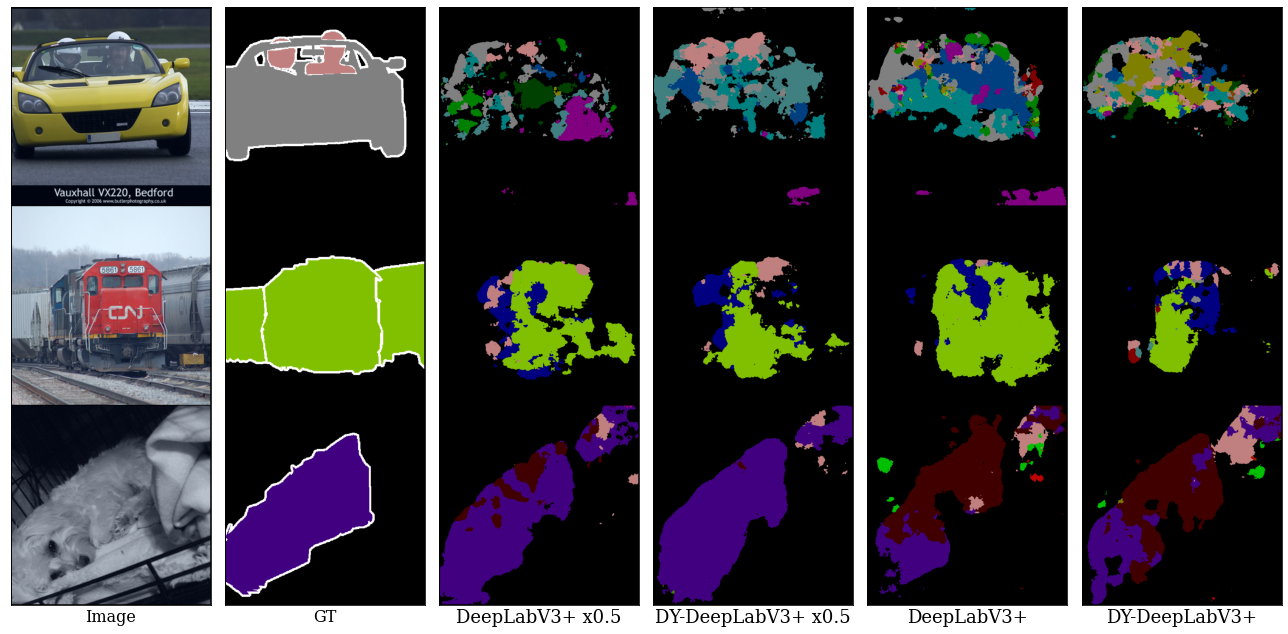

In [168]:
plot_segmentation(image, gt, [
    ("DeepLabV3+ x0.5", "../project/configs/deeplabv3plus_0.5.yaml", "0.5/baseline/cp.pth"),
    ("DY-DeepLabV3+ x0.5", "../project/configs/dy_deeplabv3plus_0.5.yaml", "0.5/dy/cp.pth"),
    ("DeepLabV3+", "../project/configs/deeplabv3plus.yaml", "1.0_no_ba/baseline/cp.pth"),
    ("DY-DeepLabV3+", "../project/configs/dy_deeplabv3plus.yaml", "1.0_no_ba/dy/cp.pth")
])